In [1]:
from tqdm import tqdm
import pandas as pd
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../../src')
from DataHandler import DataHandler

In [3]:
dataHandler = DataHandler("../config.yaml")
df_aimeta = dataHandler.load_data("files.df_aimeta")
df_filemeta = dataHandler.load_data("files.df_filesmeta")
df_opalmeta = dataHandler.load_data("files.df_opalmeta")

/media/sz/Data/Connected_Lecturers/Opal_transfer/raw/OPAL_ai_meta.p
/media/sz/Data/Connected_Lecturers/Opal_transfer/raw/OPAL_files_meta.p
/media/sz/Data/Connected_Lecturers/Opal_transfer/raw/OPAL_files_attrib.p


In [4]:
print(f"Gesamtanzahl der Datensätze {df_opalmeta.shape[0]}")

Gesamtanzahl der Datensätze 14934


In [5]:
# extract those pipe:IDs that exist in all three dataframes
df_aimeta_ids = set(df_aimeta['pipe:ID'])
df_filemeta_ids = set(df_filemeta['pipe:ID'])
df_opalmeta_ids = set(df_opalmeta['pipe:ID'])
df_common_ids = df_aimeta_ids.intersection(df_filemeta_ids).intersection(df_opalmeta_ids)
print(f"Gesamtanzahl der Datensätze {len(df_common_ids)}")

Gesamtanzahl der Datensätze 4548


In [6]:
# Create filtered dataframes first
df_file_filtered = df_filemeta[['pipe:ID', 'file:revisedAuthor']][df_filemeta['pipe:ID'].isin(df_common_ids)]
df_ai_filtered = df_aimeta[['pipe:ID', 'ai:revisedAuthor']][df_aimeta['pipe:ID'].isin(df_common_ids)]
df_opal_filtered = df_opalmeta[['pipe:ID', 'opal:revisedAuthor']][df_opalmeta['pipe:ID'].isin(df_common_ids)]

# Merge all three dataframes on 'pipe:ID'
merged_df = df_file_filtered.merge(
    df_ai_filtered, on='pipe:ID', how='inner'
).merge(
    df_opal_filtered, on='pipe:ID', how='inner'
).reset_index(drop=True)

# Display the merged dataframe
#merged_df = merged_df.iloc[2715:2725]
merged_df.shape

(4548, 4)

In [7]:
merged_df = merged_df[['pipe:ID', 'opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor']]

merged_df

,pipe:ID,opal:revisedAuthor,file:revisedAuthor,ai:revisedAuthor
0,8I6sM5zapD60,,,[Vorname='Stephan' Familienname='Gerhold' Tite...
1,8ZICOHBmAHyQ,,,[]
2,8Lfz8SAKa6k0,,,[Vorname='Robert' Familienname='Ringel' Titel='']
3,3ztCv-WpxJ4U,,,[Vorname='Norbert' Familienname='Engemaier' Ti...
4,6mOhjfscZK2A,,,[]
...,...,...,...,...
4543,8Qx2WQd_ANdI,,[],[Vorname='Sabina' Familienname='Tsapaeva' Tite...
4544,7rwytM7w-8HE,,,[]
4545,8MBQRpA2XSQU,,[Vorname='Alex' Familienname='' Titel=''],[]
4546,10MPMUvFFT_H0,,,[Vorname='Marco' Familienname='Hamann' Titel='...


## Vorbereitung des Datensatzes

In [8]:

def remove_titles(name_list):
    """Entfernt Titel aus einer Liste von Namensobjekten."""
    if isinstance(name_list, float):
        return None
    if name_list is None:
        return name_list
    if name_list is None:
        return None
    for name in name_list:
        if hasattr(name, 'Titel'):
            del name.Titel
    return name_list

merged_df['opal:revisedAuthor'] = merged_df['opal:revisedAuthor'].apply(remove_titles)
merged_df['file:revisedAuthor'] = merged_df['file:revisedAuthor'].apply(remove_titles)
merged_df['ai:revisedAuthor'] = merged_df['ai:revisedAuthor'].apply(remove_titles)

In [9]:
merged_df["ai:revisedAuthor"].apply(lambda x: len(x) if x is not None else 0)\
    .value_counts().sort_index()


ai:revisedAuthor
0     1417
1     2064
2      581
3      213
4       82
5       40
6       21
7       19
8       15
9       14
10      13
11      15
12       8
13       5
14       6
15       8
16       2
17       1
19       2
20       3
21       2
22       1
23       1
24       2
26       1
27       3
30       1
34       1
35       1
37       1
39       1
44       1
47       1
51       1
55       1
Name: count, dtype: int64

In [10]:
# Lösche Einträge mit mehr als 10 Autoren
max_authors = 10
print(merged_df.shape[0])
merged_df = merged_df[merged_df["ai:revisedAuthor"].apply(lambda x: len(x) if x is not None else 0) <= max_authors]
print(merged_df.shape[0])

4548
4479


In [11]:
# lösche alle Einträge in den Personenlisten, wo der Familienname leer ist
def remove_no_family_name(name_list):
    """Entfernt Namen ohne Familiennamen aus einer Liste von Namensobjekten."""
    if isinstance(name_list, float) or name_list is None:
        return None
    
    # Erstelle eine neue Liste mit nur den Namen, die einen Familiennamen haben
    filtered_names = [name for name in name_list 
                     if hasattr(name, 'Familienname') and name.Familienname != ""]
    
    return filtered_names if filtered_names else None

# Verwende .copy() um explizit mit einer Kopie zu arbeiten und Warnings zu vermeiden
merged_df = merged_df.copy()

merged_df['opal:revisedAuthor'] = merged_df['opal:revisedAuthor'].apply(remove_no_family_name)
merged_df['file:revisedAuthor'] = merged_df['file:revisedAuthor'].apply(remove_no_family_name)
merged_df['ai:revisedAuthor'] = merged_df['ai:revisedAuthor'].apply(remove_no_family_name)


## Frage 1: Sollte für den Vergleich der Autorendaten nur der Nachname oder auch der Vorname verwendet werden?

In [12]:
# In wie vielen Fällen finden sich nicht leere Namensobjekte pro Spalte?
def count_non_empty_names(df, column):
    """Zählt die Anzahl der nicht leeren Namensobjekte in einer DataFrame-Spalte."""
    return df[column].apply(lambda x: 1 if x is not None else 0).sum()

# Zähle in allen drei Spalten die Anzahl der Einträge, in denen der Vorname leer ist
def count_empty_first_names(df, column):
    """Zählt die Anzahl der Einträge, in denen der Vorname leer ist."""
    return df[column].apply(lambda x: 1 if x is not None and any(name.Vorname == "" for name in x) else 0).sum()

non_empty_opal = count_non_empty_names(merged_df, 'opal:revisedAuthor')
non_empty_file = count_non_empty_names(merged_df, 'file:revisedAuthor')
non_empty_ai = count_non_empty_names(merged_df, 'ai:revisedAuthor')

empty_first_names_opal = count_empty_first_names(merged_df, 'opal:revisedAuthor')
empty_first_names_file = count_empty_first_names(merged_df, 'file:revisedAuthor')
empty_first_names_ai = count_empty_first_names(merged_df, 'ai:revisedAuthor')

df_overview = pd.DataFrame({
    'Spalte': ['opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor'],
    'Nicht leere Einträge': [non_empty_opal, non_empty_file, non_empty_ai],
    'Leere Vornamen': [empty_first_names_opal, empty_first_names_file, empty_first_names_ai]
})

df_overview['ratio'] = df_overview['Leere Vornamen'] / df_overview['Nicht leere Einträge'] 

df_overview

,Spalte,Nicht leere Einträge,Leere Vornamen,ratio
0,opal:revisedAuthor,216,0,0.000000
1,file:revisedAuthor,1885,1,0.000531
2,ai:revisedAuthor,2794,22,0.007874


In [13]:
def count_identical_names(row, columns=['opal:authorRevised', 'file:authorRevised', 'ai:authorRevised'], match_first_name=True):
    """
    Zählt identische Namen zwischen verschiedenen Spalten.
    
    Args:
        row: Die DataFrame-Zeile
        columns: Die zu vergleichenden Spalten
        match_first_name: Wenn True, müssen Vor- und Nachname übereinstimmen, sonst nur der Nachname
        
    Returns:
        int: Die Anzahl der identischen Namen zwischen den Spalten
    """
    name_sets = []
    
    for column in columns:
        if column not in row:
            raise ValueError(f"Column '{column}' not found in the row.")
        
        # Erstelle ein Set aus den Namen in dieser Spalte
        name_set = set()
        if row[column] is not None:
            # Je nach Parameter unterschiedliche Elemente ins Set einfügen
            if match_first_name:
                # Vor- und Nachname als Tuple (beide müssen übereinstimmen)
                name_set = set(tuple((n.Vorname, n.Familienname)) for n in row[column])
            else:
                # Nur den Nachnamen (es reicht, wenn nur dieser übereinstimmt)
                name_set = set(n.Familienname for n in row[column])
        
        name_sets.append(name_set)
    
    # Wenn keine Sets vorhanden sind, return 0
    if not name_sets:
        return 0
    
    # Starte mit dem ersten Set als Basis für die Schnittmenge
    intersection = name_sets[0]
    
    # Berechne die Schnittmenge mit allen weiteren Sets
    for name_set in name_sets[1:]:
        intersection = intersection.intersection(name_set)
    
    return len(intersection)

# Verschiedene Spaltenkombinationen definieren
column_combinations = [
    ['opal:revisedAuthor', 'file:revisedAuthor'],
    ['opal:revisedAuthor', 'ai:revisedAuthor'],
    ['file:revisedAuthor', 'ai:revisedAuthor'],
    ['opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor']
]

# Für jede Kombination und jede Vergleichsart die Anzahl identischer Namen berechnen
for match_first_name in [True, False]:
    name_match_type = "Vor_Nachname" if match_first_name else "NurNachname"
    print(f"\n--- Analyse mit {name_match_type} ---")
    
    for cols in column_combinations:
        col_name = f"identical_{name_match_type}_" + '_'.join([c.split(':')[0] for c in cols])
        
        merged_df[col_name] = merged_df.apply(
            count_identical_names, 
            axis=1, 
            columns=cols,
            match_first_name=match_first_name
        )
        
        identical_count = (merged_df[col_name] > 0).sum()
        print(f"Einträge mit mind. einem identischen Namen zwischen {cols}: {identical_count}")


--- Analyse mit Vor_Nachname ---
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'file:revisedAuthor']: 164
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'ai:revisedAuthor']: 149
Einträge mit mind. einem identischen Namen zwischen ['file:revisedAuthor', 'ai:revisedAuthor']: 705
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor']: 122

--- Analyse mit NurNachname ---
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'file:revisedAuthor']: 165
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'ai:revisedAuthor']: 165
Einträge mit mind. einem identischen Namen zwischen ['file:revisedAuthor', 'ai:revisedAuthor']: 765
Einträge mit mind. einem identischen Namen zwischen ['opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor']: 139
Einträge mit mind. einem identischen Namen zwischen ['file:revisedAuthor', 'ai:revise

## Frage 2: Kann man anhand der OPAL Metadaten eine Fehlerabschätzung vornehmen?

In [14]:
opal_df = merged_df[
    # Has OPAL authors
    ~merged_df['opal:revisedAuthor'].isna() 
]

In [15]:
def calculate_name_overlap(row, columns=['opal:authorRevised', 'ai:authorRevised'], match_first_name=False):
    """
    Berechnet die Überschneidung zwischen Autoren aus zwei Quellen
    
    Args:
        row: Die DataFrame-Zeile
        columns: Die zu vergleichenden Spalten (genau 2 Spalten)
        match_first_name: Wenn True, müssen Vor- und Nachname übereinstimmen, sonst nur der Nachname
        
    Returns:
        dict: Ein Dictionary mit Werten für Überschneidung, Jaccard-Index und anderen Kennzahlen
    """
    if len(columns) != 2:
        raise ValueError("Diese Funktion benötigt genau 2 Spalten zum Vergleich")
    
    opal_col, ai_col = columns
    
    # Erstelle Sets für beide Quellen
    opal_names = set()
    ai_names = set()
    
    if row[opal_col] is not None:
        if match_first_name:
            opal_names = set(tuple((n.Vorname, n.Familienname)) for n in row[opal_col])
        else:
            opal_names = set(n.Familienname for n in row[opal_col])
            
    if row[ai_col] is not None:
        if match_first_name:
            ai_names = set(tuple((n.Vorname, n.Familienname)) for n in row[ai_col])
        else:
            ai_names = set(n.Familienname for n in row[ai_col])
    
    # Berechne Kennzahlen
    intersection = opal_names.intersection(ai_names)
    union = opal_names.union(ai_names)
    
    # Anzahl übereinstimmender Namen
    overlap_count = len(intersection)
    
    # Jaccard-Index: Überschneidung / Vereinigung (0 bis 1, höher = mehr Überschneidung)
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0
    
    # Recall: Wie viele der OPAL-Namen wurden von AI gefunden? (0 bis 1)
    recall = len(intersection) / len(opal_names) if len(opal_names) > 0 else 0
    
    # Precision: Wie viele der von AI gefundenen Namen sind tatsächlich in OPAL? (0 bis 1)
    precision = len(intersection) / len(ai_names) if len(ai_names) > 0 else 0
    
    # F1-Score: Harmonisches Mittel zwischen Precision und Recall (0 bis 1)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    result = {
        'overlap_count': overlap_count,
        'jaccard': jaccard,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'opal_count': len(opal_names),
        'ai_count': len(ai_names)
    }
    
    return result

# Anwendung auf den DataFrame - nur Nachname vergleichen (match_first_name=False)
match_first_name = True
overlap_results = opal_df.apply(
    lambda row: calculate_name_overlap(
        row, 
        columns=['opal:revisedAuthor', 'ai:revisedAuthor'], 
        match_first_name=match_first_name
    ),
    axis=1
)

# Erstelle für jede Metrik eine eigene Spalte
for metric in ['overlap_count', 'opal_count']:
    column_name = f"OPAL_AI_{metric}"
    opal_df[column_name] = overlap_results.apply(lambda x: x[metric])

opal_df

/tmp/ipykernel_54272/3978874945.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opal_df[column_name] = overlap_results.apply(lambda x: x[metric])
/tmp/ipykernel_54272/3978874945.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opal_df[column_name] = overlap_results.apply(lambda x: x[metric])


,pipe:ID,opal:revisedAuthor,file:revisedAuthor,ai:revisedAuthor,identical_Vor_Nachname_opal_file,identical_Vor_Nachname_opal_ai,identical_Vor_Nachname_file_ai,identical_Vor_Nachname_opal_file_ai,identical_NurNachname_opal_file,identical_NurNachname_opal_ai,identical_NurNachname_file_ai,identical_NurNachname_opal_file_ai,OPAL_AI_overlap_count,OPAL_AI_opal_count
100,10B6d60xs9Cys,[Vorname='Frank' Familienname='Babick'],[Vorname='Frank' Familienname='Babick'],[Vorname='Frank' Familienname='Babick'],1,1,1,1,1,1,1,1,1,1
118,12aflSOUs_e7c,[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'],1,1,1,1,1,1,1,1,1,1
191,3kcnKgnSAtpk,[Vorname='Jens-uwe' Familienname='Grabowski'],None,[Vorname='Ralf' Familienname='Romeike'],0,0,0,0,0,0,0,0,0,1
256,43Kq3-1Ku-1A,[Vorname='Nadine' Familienname='Bergner'],[Vorname='Nadine' Familienname='Bergner'],[Vorname='Nadine' Familienname='Bergner'],1,1,1,1,1,1,1,1,1,1
291,52NSb-r7L844,[Vorname='Jost-Hinrich' Familienname='Eschenbu...,[Vorname='Jost-Hinrich' Familienname='Eschenbu...,[Vorname='J.-H.' Familienname='Eschenburg'],1,0,0,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,8UOyIeIZw9dM,[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'...,1,1,1,1,1,1,1,1,1,1
4467,9NUSW9eh1Jc0,[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'],None,1,0,0,0,1,0,0,0,0,1
4505,5ySw59JFdyX4,[Vorname='Frank' Familienname='Babick'],[Vorname='Frank' Familienname='Babick'],[Vorname='Frank' Familienname='Babick'],1,1,1,1,1,1,1,1,1,1
4511,8V8HEsBlOUQ8,[Vorname='Johann' Familienname='Zitzelsberger'],[Vorname='Johann' Familienname='Zitzelsberger'],None,1,0,0,0,1,0,0,0,0,1


In [16]:
opal_df.groupby(['OPAL_AI_overlap_count', 'OPAL_AI_opal_count'])['pipe:ID'].count().unstack().fillna(0).astype(int)

OPAL_AI_opal_count,1,2,3,4
OPAL_AI_overlap_count,,,,
0,55,10,1,1
1,138,3,0,0
2,0,5,1,0
3,0,0,2,0


## Generierung eines Venn-Diagramms

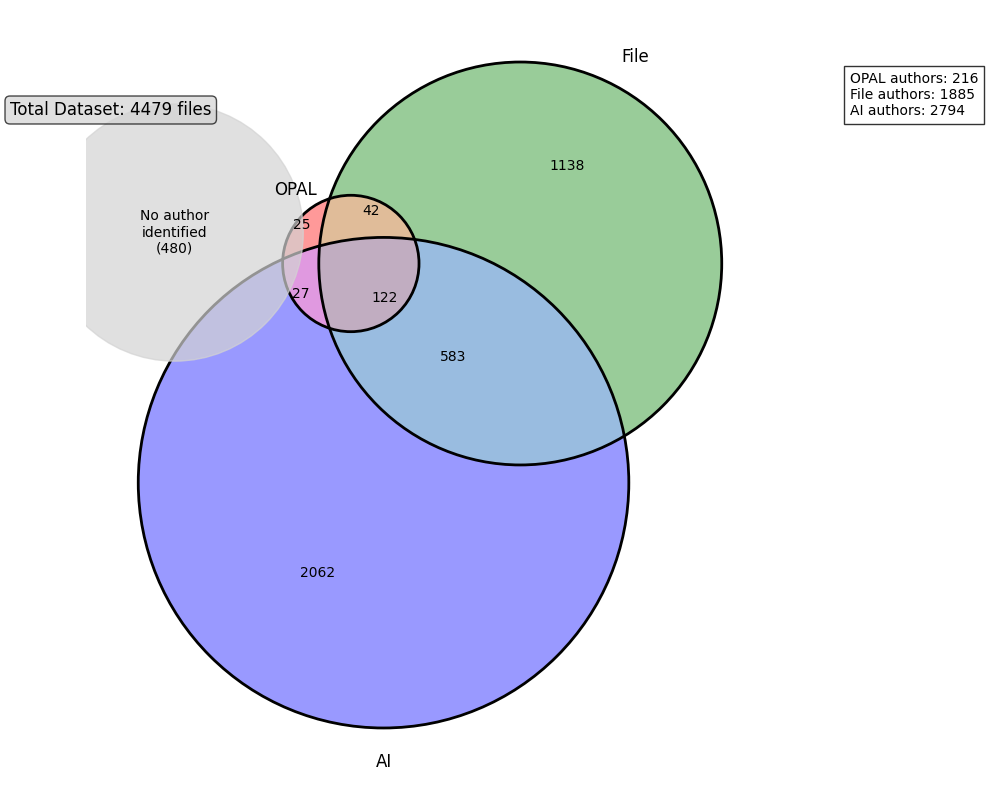

In [17]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import matplotlib.patches as patches
import numpy as np

# Get total dataset size
total_dataset_size = merged_df.shape[0]

# Calculate unique counts for each set
opal_count = count_non_empty_names(merged_df, 'opal:revisedAuthor')
file_count = count_non_empty_names(merged_df, 'file:revisedAuthor')
ai_count = count_non_empty_names(merged_df, 'ai:revisedAuthor')

match_first_name=True

# Get intersection counts from the columns you already calculated
opal_file_intersection = merged_df.apply(
        count_identical_names, 
        axis=1, 
        columns= ['opal:revisedAuthor', 'file:revisedAuthor'],
        match_first_name=match_first_name
    ).apply(lambda x: x > 0).sum()

opal_ai_intersection = merged_df.apply(
        count_identical_names, 
        axis=1, 
        columns= ['opal:revisedAuthor', 'ai:revisedAuthor'],
        match_first_name=match_first_name
    ).apply(lambda x: x > 0).sum()

file_ai_intersection = merged_df.apply(
        count_identical_names, 
        axis=1, 
        columns= ['file:revisedAuthor', 'ai:revisedAuthor'],
        match_first_name=match_first_name
    ).apply(lambda x: x > 0).sum()

all_intersection = merged_df.apply(
        count_identical_names, 
        axis=1, 
        columns= ['opal:revisedAuthor', 'file:revisedAuthor', 'ai:revisedAuthor'],
        match_first_name=match_first_name
    ).apply(lambda x: x > 0).sum()

# Calculate region sizes for venn3 diagram
opal_only = opal_count - (opal_file_intersection + opal_ai_intersection - all_intersection)
file_only = file_count - (opal_file_intersection + file_ai_intersection - all_intersection)
ai_only = ai_count - (opal_ai_intersection + file_ai_intersection - all_intersection)
opal_file_only = opal_file_intersection - all_intersection
opal_ai_only = opal_ai_intersection - all_intersection
file_ai_only = file_ai_intersection - all_intersection

# Create figure with specific size
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Create the Venn diagram - centered in our figure
venn = venn3(
    subsets=(
        opal_only,        # A
        file_only,        # B
        opal_file_only,   # AB
        ai_only,          # C
        opal_ai_only,     # AC
        file_ai_only,     # BC
        all_intersection  # ABC
    ),
    set_labels=('OPAL', 'File', 'AI')
)

# Add circles for better visibility of the Venn diagram
venn3_circles(subsets=(
    opal_only, file_only, opal_file_only, 
    ai_only, opal_ai_only, file_ai_only, 
    all_intersection
))


# Customize the diagram
#plt.title('Overlap of Author Names within Dataset', fontsize=16)

# Calculate "no author identified" count
no_author_identified = total_dataset_size - (opal_count + file_count + ai_count - 
                                           opal_file_intersection - opal_ai_intersection - 
                                           file_ai_intersection + all_intersection)

no_author_radius = np.sqrt(no_author_identified / np.pi) / 50  # Skaliere angemessen
if no_author_identified > 0:  # Nur anzeigen, wenn es solche Dokumente gibt
    no_author_circle = plt.Circle((-0.5, 0.3), no_author_radius, 
                                  color='lightgray', alpha=0.7)
    ax.add_patch(no_author_circle)
    plt.text(-0.5, 0.3, f"No author\nidentified\n({no_author_identified})", 
             ha='center', va='center', fontsize=10)

# Add annotation for total dataset
plt.figtext(0.15, 0.85, f"Total Dataset: {total_dataset_size} files", 
            bbox=dict(facecolor='lightgray', alpha=0.7, boxstyle='round'), fontsize=12)

# Display counts for each system
plt.figtext(0.85, 0.85, f"OPAL authors: {opal_count}\nFile authors: {file_count}\nAI authors: {ai_count}", 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

## Detailuntersuchung

In [18]:
import os
import glob
from tqdm import tqdm

folder = "/media/sz/Data/Connected_Lecturers/Opal_crosslab/raw/content"
zeidler_files = []


# Check if the folder exists
if not os.path.exists(folder):
    print(f"Folder {folder} does not exist.")

# Get all files in the directory
files = glob.glob(os.path.join(folder, "*"))

# Process each file
for file_path in tqdm(files, desc="Searching files"):
    try:
        # Get filename without extension
        filename = os.path.splitext(os.path.basename(file_path))[0]
        
        # Check if it's a text-based file (you can add more extensions if needed)
        if os.path.isfile(file_path) and os.path.getsize(file_path) < 40 * 1024 * 1024:  # Skip files larger than 10MB
            with open(file_path, 'r', errors='ignore') as f:
                content = f.read()
                if "Henning Zeidler" in content:
                    zeidler_files.append(filename)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print(f"Found {len(zeidler_files)} files containing 'Henning Zeidler'")
print(zeidler_files[:10])  # Print first 10 files for preview


Searching files:   0%|          | 0/8108 [00:00<?, ?it/s]

Searching files: 100%|██████████| 8108/8108 [00:01<00:00, 5403.54it/s]

Found 351 files containing 'Henning Zeidler'
['4r-sUb1RsLGw', '3yhBCakwup0U', '5CkogiacELDc', '6yKSFHSa9zds', '12PE7hoWVLGjA', '8hp9nxZgW_XA', '42uuigxnv0Fg', '85KwJO4zDhJA', '3tKlx64FGN38', '4MRVeZKE5fgY']


In [19]:
# welche Zeidler Dateien sind nicht in df_merged enthalten?
zeidler_files_set = set(zeidler_files)
df_merged_set = set(merged_df['pipe:ID'])
not_in_merged = zeidler_files_set - df_merged_set
print(f"Anzahl der Zeidler-Dateien, die nicht in df_merged enthalten sind: {len(not_in_merged)}")
print(not_in_merged) 
# welche Zeidler Dateien sind in df_merged enthalten?
in_merged = zeidler_files_set.intersection(df_merged_set)
print(f"Anzahl der Zeidler-Dateien, die in df_merged enthalten sind: {len(in_merged)}")
print(in_merged)  # Print the files that are in df_merged
# Zeidler-Dateien, die in df_merged enthalten sind

Anzahl der Zeidler-Dateien, die nicht in df_merged enthalten sind: 258
{'3k7-Yvm3h04E', '312MMZYLrq4E', '3OAO9n1So8c0', '3s7zmr0UBmT0', '3_m2BWT_lOLA', '3KruRlEoWqic', '4APheiSsZruo', '32_hkBvi0rb0', '3tKlx64FGN38', '4e31UMwjU73U', '11dtp7w1Mlw9g', '3rBKAkbNe0AI', '3JDXrz36yF0A', '11303ZKezyroo', '12p1zruVAQwdQ', '3cXs8e9VGLlg', '3TRtcx1sz8qE', '3UhtG3wpbV_8', '31BDmhDUZa2o', '6UKJYLjf2UmU', '3J4BhIOk1I4s', '3crcUBsbwfKc', '3td3QkB-Rq5c', '3APNk-p5potU', '11NnyRGxORaHo', '11VycnfczR7L4', '3ku1eAcTDq2k', '11rP1CfHTeXkA', '11JnAzgzQfJeg', '3Sh2lEhPcjAA', '4Zrq8FxfNMwk', '4EkviQhi7NuQ', '3D_IZ7JNPJOI', '3CrR3xMzyVpQ', '3dFO7pGJtoUY', '3abInp9jGY-g', '4-wrRcPA2H6A', '3SwMZiZwm8CI', '308JR8Eka7UI', '4j02F2KFZuMA', '33ZsDJ6mSKoI', '47dasYpsyyP4', '3PTmD0qcH0jo', '11ejdlREFwmMY', '4l_BaCypRaSc', '3DdA9Q4QxtRQ', '3-qQXz8PPG9I', '4JxTWFV-x3lw', '3qAsC229F0RQ', '4Bl5-32KpIo4', '11QjpwxMfGz94', '3s2VmApyZKSQ', '11JjaOEDALjTM', '3BBw6IqzYsBI', '106eDXVtxfYBQ', '38mg750W4Yr8', '17EzWPcGwd9N4', '3yh

In [20]:
# Extrahiere die zeidler_files aus dem DataFrame
def extract_zeidler_files(df, zeidler_files):
    """Extrahiere die Zeidler-Dateien aus dem DataFrame."""
    return df[df['pipe:ID'].isin(zeidler_files)]

zeidler_df = extract_zeidler_files(merged_df, zeidler_files)

zeidler_df

,pipe:ID,opal:revisedAuthor,file:revisedAuthor,ai:revisedAuthor,identical_Vor_Nachname_opal_file,identical_Vor_Nachname_opal_ai,identical_Vor_Nachname_file_ai,identical_Vor_Nachname_opal_file_ai,identical_NurNachname_opal_file,identical_NurNachname_opal_ai,identical_NurNachname_file_ai,identical_NurNachname_opal_file_ai
189,3wPrkJlM9uY8,None,[Vorname='Henning' Familienname='Zeidler'],[Vorname='Henning' Familienname='Zeidler'],0,0,1,0,0,0,1,0
242,723L8Ft5Ms80,None,None,"[Vorname='Terry' Familienname='Wohlers', Vorna...",0,0,0,0,0,0,0,0
342,1K6PY1moVSwQ,None,[Vorname='Henning' Familienname='Zeidler'],"[Vorname='Henning' Familienname='Zeidler', Vor...",0,0,1,0,0,0,1,0
433,6tOeO_uR9h9E,None,[Vorname='Henning' Familienname='Zeidler'],[Vorname='Henning' Familienname='Zeidler'],0,0,1,0,0,0,1,0
691,7e8yT46h9xyY,None,None,[Vorname='Henning' Familienname='Zeidler'],0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2873,91AZKfFJxv44,None,None,[Vorname='Henning' Familienname='Zeidler'],0,0,0,0,0,0,0,0
2874,9B3a6FlotEms,None,None,[Vorname='Henning' Familienname='Zeidler'],0,0,0,0,0,0,0,0
2875,9mKHm68tgAI0,None,None,[Vorname='Henning' Familienname='Zeidler'],0,0,0,0,0,0,0,0
2876,9jg_2sauMsCE,None,None,"[Vorname='Jürgen' Familienname='Griebsch', Vor...",0,0,0,0,0,0,0,0


In [35]:
# Identifiziere die Zeidler-Dateien, die weder in File_revisedAuthor noch in ai:revisedAuthor den Familiennamen "Zeidler" enthalten
def identify_zeidler_files(df):
    """Identifiziere die Zeidler-Dateien, die weder in File_revisedAuthor noch in ai:revisedAuthor den Familiennamen 'Zeidler' enthalten."""
    zeidler_files = []
    
    for index, row in df.iterrows():
        file_authors = row['file:revisedAuthor']
        ai_authors = row['ai:revisedAuthor']
        
        # Check if 'Zeidler' is in either of the author lists
        if ai_authors is None or not any(name.Familienname == "Zeidler" for name in ai_authors):
            zeidler_files.append(row['pipe:ID'])
    
    return zeidler_files        

zeidler_files_not_in_authors = identify_zeidler_files(zeidler_df)
zeidler_df[zeidler_df["pipe:ID"].isin(zeidler_files_not_in_authors)]

,pipe:ID,opal:revisedAuthor,file:revisedAuthor,ai:revisedAuthor,identical_Vor_Nachname_opal_file,identical_Vor_Nachname_opal_ai,identical_Vor_Nachname_file_ai,identical_Vor_Nachname_opal_file_ai,identical_NurNachname_opal_file,identical_NurNachname_opal_ai,identical_NurNachname_file_ai,identical_NurNachname_opal_file_ai
242,723L8Ft5Ms80,None,None,"[Vorname='Terry' Familienname='Wohlers', Vorna...",0,0,0,0,0,0,0,0
1930,6Aqc3cVXgDvQ,None,[Vorname='Henning' Familienname='Zeidler'],[Vorname='A. H.' Familienname='Fritz'],0,0,0,0,0,0,0,0
1939,89ApOB5CiB0c,None,[Vorname='Henning' Familienname='Zeidler'],"[Vorname='A. H.' Familienname='Fritz', Vorname...",0,0,0,0,0,0,0,0
2207,7CLAnJCIjP1g,None,[Vorname='Henning' Familienname='Zeidler'],"[Vorname='Jürgen' Familienname='Grüner', Vorna...",0,0,0,0,0,0,0,0
2238,123yfS1zEhqqM,None,[Vorname='Henning' Familienname='Zeidler'],[Vorname='Hans-Jürgen' Familienname='Warnecke'],0,0,0,0,0,0,0,0
2876,9jg_2sauMsCE,None,None,"[Vorname='Jürgen' Familienname='Griebsch', Vor...",0,0,0,0,0,0,0,0
